In [29]:
from neo4j import GraphDatabase

uri = 'bolt://localhost:7687'
user = 'neo4j'
password = 'nbadataset'
db_name = 'nba'

driver = GraphDatabase.driver(uri,auth=(user,password))
driver.verify_connectivity()
print('connessione a neo4j riuscita!')

with driver.session(database=db_name) as session:
    print(f'Sessione aperta con successo al database: {db_name}')
    result = session.run("MATCH (n) RETURN count(n) AS node_count")
    record = result.single() # Ottieni il singolo record risultato
    if record:
        print(f"Numero di nodi nel database '{db_name}': {record['node_count']}")
    else:
        print(f"Nessun record restituito dalla query di conteggio nodi nel database '{db_name}'.")

connessione a neo4j riuscita!
Sessione aperta con successo al database: nba
Numero di nodi nel database 'nba': 8621


Importazione delle squadre 

In [ ]:
import pandas as pd 

df = pd.read_csv('teams_for_neo4j.csv')

df.info()

In [5]:
# --- Funzione per creare Constraints (assicurati sia stata eseguita una volta) ---
def create_constraints_for_schema(neo4j_session):
    print("Tentativo di creazione constraints...")
    neo4j_session.run("""
        CREATE CONSTRAINT IF NOT EXISTS FOR (t:Team)
        REQUIRE t.teamId IS UNIQUE;
    """)
    print("Constraints per :Team creati (o già esistenti).")

# --- Funzione per importare le Squadre (MODIFICATA) ---
def import_teams_data(neo4j_session, csv_filename="teams_for_neo4j.csv"):
    """
    Importa le squadre dal file CSV specificato.
    Il file CSV deve trovarsi nella cartella 'import' del database Neo4j.
    """
    print(f"Inizio importazione squadre da '{csv_filename}'...")
    
    import_query = """
    LOAD CSV WITH HEADERS FROM $csvFileUrl AS row // Nome parametro cambiato per chiarezza
    FIELDTERMINATOR ','
    MERGE (t:Team {teamId: toInteger(row.TEAM_ID)})
    ON CREATE SET
        t.leagueId = toInteger(row.LEAGUE_ID),
        t.minYear = toInteger(row.MIN_YEAR),
        t.maxYear = toInteger(row.MAX_YEAR),
        t.abbreviation = row.ABBREVIATION,
        t.nickname = row.NICKNAME,
        t.yearFounded = toInteger(row.YEARFOUNDED),
        t.city = row.CITY,
        t.arena = row.ARENA,
        t.owner = row.OWNER,
        t.generalManager = row.GENERALMANAGER,
        t.headCoach = row.HEADCOACH,
        t.dLeagueAffiliation = row.DLEAGUEAFFILIATION
    ON MATCH SET
        t.leagueId = toInteger(row.LEAGUE_ID),
        t.minYear = toInteger(row.MIN_YEAR),
        t.maxYear = toInteger(row.MAX_YEAR),
        t.abbreviation = row.ABBREVIATION,
        t.nickname = row.NICKNAME,
        t.yearFounded = toInteger(row.YEARFOUNDED),
        t.city = row.CITY,
        t.arena = row.ARENA,
        t.owner = row.OWNER,
        t.generalManager = row.GENERALMANAGER,
        t.headCoach = row.HEADCOACH,
        t.dLeagueAffiliation = row.DLEAGUEAFFILIATION
    """
    
    # URL del file per Neo4j, specificando il protocollo 'file:///'
    file_url_for_neo4j = 'file:///' + csv_filename
    
    neo4j_session.run(import_query, csvFileUrl=file_url_for_neo4j) # Passa l'URL costruito
    print(f"Importazione squadre da '{csv_filename}' (usando URL: {file_url_for_neo4j}) completata.")

# --- Esecuzione delle operazioni nel contesto della sessione Neo4j ---
try:
    with driver.session(database=db_name) as session:
        print(f"Utilizzo della sessione esistente con il database: '{db_name}' per l'importazione.")
        
        # 1. Crea i constraints 
        create_constraints_for_schema(session) # Commenta se già eseguito con successo
        
        # 2. Importa le squadre
        import_teams_data(session, csv_filename="teams_for_neo4j.csv")
        
        # 3. Verifica il numero di nodi Team creati
        result = session.run("MATCH (t:Team) RETURN count(t) AS team_count")
        count_record = result.single()
        if count_record:
            print(f"Numero totale di nodi :Team nel database '{db_name}': {count_record['team_count']}")
        else:
            print(f"Nessun nodo :Team trovato dopo l'importazione.")

except Exception as e:
    print(f"Si è verificato un errore durante le operazioni con Neo4j: {e}")
    print("Controlla i messaggi di errore per dettagli specifici.")


Utilizzo della sessione esistente con il database: 'nba' per l'importazione.
Inizio importazione squadre da 'teams_for_neo4j.csv'...
Importazione squadre da 'teams_for_neo4j.csv' (usando URL: file:///teams_for_neo4j.csv) completata.
Numero totale di nodi :Team nel database 'nba': 30


In [10]:
df_players = pd.read_csv('players_for_neo4j.csv')

unique_player_ids = df_players['PLAYER_ID'].nunique()
df_players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7228 entries, 0 to 7227
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PLAYER_NAME  7228 non-null   object
 1   TEAM_ID      7228 non-null   int64 
 2   PLAYER_ID    7228 non-null   int64 
 3   SEASON       7228 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 226.0+ KB


In [11]:
# Le tue variabili uri, user, password, db_name, e driver dovrebbero essere già definite.

# --- Funzione per creare Constraints (MODIFICATA per includere Player) ---
def create_constraints_for_schema(neo4j_session):
    print("Tentativo di creazione constraints...")
    # Constraint per Player
    neo4j_session.run("""
        CREATE CONSTRAINT IF NOT EXISTS FOR (p:Player)
        REQUIRE p.playerId IS UNIQUE;
    """)
    print("Constraints per :Team e :Player creati (o già esistenti).")

# --- Funzione per importare i Giocatori ---
def import_players_data(neo4j_session, csv_filename="players_for_neo4j.csv"):
    """
    Importa i giocatori dal file CSV specificato.
    Il file CSV deve trovarsi nella cartella 'import' del database Neo4j.
    Crea un solo nodo :Player per ogni PLAYER_ID unico.
    Le colonne TEAM_ID e SEASON in questo file vengono ignorate per il nodo :Player.
    """
    print(f"Inizio importazione giocatori da '{csv_filename}'...")
    

    # PLAYER_ID è la chiave univoca per i nodi :Player.
    # PLAYER_NAME diventa una proprietà.
    import_query = """
    LOAD CSV WITH HEADERS FROM $csvFileUrl AS row
    FIELDTERMINATOR ','
    MERGE (p:Player {playerId: toInteger(row.PLAYER_ID)}) // row.PLAYER_ID è int64
    ON CREATE SET // Imposta il nome solo quando il nodo viene creato la prima volta
        p.name = row.PLAYER_NAME      // row.PLAYER_NAME è object (string)
    """
    
    file_url_for_neo4j = 'file:///' + csv_filename
    
    neo4j_session.run(import_query, csvFileUrl=file_url_for_neo4j)
    print(f"Importazione giocatori da '{csv_filename}' (usando URL: {file_url_for_neo4j}) completata.")

# --- Esecuzione delle operazioni nel contesto della sessione Neo4j ---
try:
    with driver.session(database=db_name) as session:
        print(f"Utilizzo della sessione esistente con il database: '{db_name}' per l'importazione dei giocatori.")
        
        # 1. Aggiorna/Crea i constraints
        create_constraints_for_schema(session) 
        
        # 2. Importa i giocatori
        import_players_data(session, csv_filename="players_for_neo4j.csv") # Cambia se il nome file è diverso
        
        # 3. Verifica il numero di nodi Player creati
        # Questo numero dovrebbe essere il numero di PLAYER_ID UNICI, non 7228 (che è il numero di righe).
        # Per verificarlo, puoi prima vedere quanti PLAYER_ID unici ci sono nel tuo DataFrame Pandas.
        # df_players = pd.read_csv("players_for_neo4j.csv") # Se hai il DataFrame caricato
        # unique_player_ids = df_players['PLAYER_ID'].nunique()
        # print(f"Numero di PLAYER_ID unici nel CSV: {unique_player_ids}")
        
        result = session.run("MATCH (p:Player) RETURN count(p) AS player_count")
        count_record = result.single()
        if count_record:
            print(f"Numero totale di nodi :Player nel database '{db_name}': {count_record['player_count']}")
            # print(f"(Dovrebbe corrispondere al numero di PLAYER_ID unici nel tuo CSV, non al numero totale di righe del CSV dei giocatori)")
        else:
            print(f"Nessun nodo :Player trovato dopo l'importazione.")

except Exception as e:
    print(f"Si è verificato un errore durante le operazioni con Neo4j: {e}")
    print("Controlla i messaggi di errore per dettagli specifici.")


Utilizzo della sessione esistente con il database: 'nba' per l'importazione dei giocatori.
Tentativo di creazione constraints...
Constraints per :Team e :Player creati (o già esistenti).
Inizio importazione giocatori da 'players_for_neo4j.csv'...
Importazione giocatori da 'players_for_neo4j.csv' (usando URL: file:///players_for_neo4j.csv) completata.
Numero totale di nodi :Player nel database 'nba': 1769


Importazione delle partite 

In [37]:
df_games_filtered = pd.read_csv('games_filtered.csv')

df_games_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6822 entries, 0 to 6821
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GAME_DATE_EST     6822 non-null   object 
 1   GAME_ID           6822 non-null   int64  
 2   GAME_STATUS_TEXT  6822 non-null   object 
 3   HOME_TEAM_ID      6822 non-null   int64  
 4   VISITOR_TEAM_ID   6822 non-null   int64  
 5   SEASON            6822 non-null   int64  
 6   TEAM_ID_home      6822 non-null   int64  
 7   PTS_home          6822 non-null   float64
 8   FG_PCT_home       6822 non-null   float64
 9   FT_PCT_home       6822 non-null   float64
 10  FG3_PCT_home      6822 non-null   float64
 11  AST_home          6822 non-null   float64
 12  REB_home          6822 non-null   float64
 13  TEAM_ID_away      6822 non-null   int64  
 14  PTS_away          6822 non-null   float64
 15  FG_PCT_away       6822 non-null   float64
 16  FT_PCT_away       6822 non-null   float64


In [18]:
# Le tue variabili uri, user, password, db_name, e driver dovrebbero essere già definite.

# --- Funzione per creare Constraints (MODIFICATA per includere Game) ---
def create_constraints_for_schema(neo4j_session):
    print("Tentativo di creazione constraints...")
    # Constraint per Game
    neo4j_session.run("""
        CREATE CONSTRAINT IF NOT EXISTS FOR (g:Game)
        REQUIRE g.gameId IS UNIQUE;
    """)
    print("Constraints per :Team, :Player, e :Game creati (o già esistenti).")

# --- Funzione per importare le Partite e creare relazioni con le Squadre ---
def import_games_and_team_relations(neo4j_session, csv_filename="games_filtered.csv"):
    """
    Importa le partite (Games) e crea le relazioni :HOSTED_GAME e :VISITED_GAME
    con i nodi :Team esistenti.
    Il file CSV deve trovarsi nella cartella 'import' del database Neo4j.
    """
    print(f"Inizio importazione partite e relazioni con squadre da '{csv_filename}'...")
    
    # Query Cypher basata sulla struttura del tuo CSV games_filtered.csv
    import_query = """
    LOAD CSV WITH HEADERS FROM $csvFileUrl AS row
    FIELDTERMINATOR ','
    
    // Trova i nodi Team per la squadra di casa e ospite (devono già esistere)
    MATCH (homeTeam:Team {teamId: toInteger(row.HOME_TEAM_ID)})
    MATCH (visitorTeam:Team {teamId: toInteger(row.VISITOR_TEAM_ID)})
    
    // Crea (o fa il merge) del nodo Game
    MERGE (g:Game {gameId: toInteger(row.GAME_ID)})
    ON CREATE SET
        g.date = date(row.GAME_DATE_EST),       // Converte la stringa data in un tipo date di Neo4j
        g.statusText = row.GAME_STATUS_TEXT,
        g.season = toInteger(row.SEASON),
        g.homeTeamWins = CASE WHEN toInteger(row.HOME_TEAM_WINS) = 1 THEN true ELSE false END, // Converte int (0/1) a boolean
        // Statistiche generali della partita come proprietà del nodo Game
        g.ptsHome = toFloat(row.PTS_home),
        g.fgPctHome = toFloat(row.FG_PCT_home),
        g.ftPctHome = toFloat(row.FT_PCT_home),
        g.fg3PctHome = toFloat(row.FG3_PCT_home),
        g.astHome = toFloat(row.AST_home),
        g.rebHome = toFloat(row.REB_home),
        g.ptsAway = toFloat(row.PTS_away),
        g.fgPctAway = toFloat(row.FG_PCT_away),
        g.ftPctAway = toFloat(row.FT_PCT_away),
        g.fg3PctAway = toFloat(row.FG3_PCT_away),
        g.astAway = toFloat(row.AST_away),
        g.rebAway = toFloat(row.REB_away)
        // Le colonne TEAM_ID_home e TEAM_ID_away nel CSV sono ridondanti 
        // se corrispondono a HOME_TEAM_ID e VISITOR_TEAM_ID, quindi non le usiamo direttamente sul nodo Game.
        // Le usiamo per fare il MATCH dei nodi Team.
        
    // Crea le relazioni tra Squadre e Partita
    MERGE (homeTeam)-[:HOSTED_GAME]->(g)
    MERGE (visitorTeam)-[:VISITED_GAME]->(g)
    """
    
    file_url_for_neo4j = 'file:///' + csv_filename
    
    neo4j_session.run(import_query, csvFileUrl=file_url_for_neo4j)
    print(f"Importazione partite e relazioni da '{csv_filename}' (usando URL: {file_url_for_neo4j}) completata.")

# --- Esecuzione delle operazioni nel contesto della sessione Neo4j ---
try:
    with driver.session(database=db_name) as session:
        print(f"Utilizzo della sessione esistente con il database: '{db_name}' per l'importazione delle partite.")
        
        # 1. Crea i constraints 
        create_constraints_for_schema(session) 
        
        # 2. Importa le partite e crea le relazioni con le squadre
        import_games_and_team_relations(session, csv_filename="games_filtered.csv") # Cambia se il nome file è diverso
        
        # 3. Verifica il numero di nodi Game e relazioni create
        game_count_result = session.run("MATCH (g:Game) RETURN count(g) AS game_count")
        game_count_record = game_count_result.single()
        if game_count_record:
            print(f"Numero totale di nodi :Game nel database '{db_name}': {game_count_record['game_count']}")
        else:
            print(f"Nessun nodo :Game trovato dopo l'importazione.")
            
        hosted_rels_result = session.run("MATCH (:Team)-[r:HOSTED_GAME]->(:Game) RETURN count(r) AS hosted_rels_count")
        hosted_rels_record = hosted_rels_result.single()
        if hosted_rels_record:
            print(f"Numero totale di relazioni :HOSTED_GAME: {hosted_rels_record['hosted_rels_count']}")

        visited_rels_result = session.run("MATCH (:Team)-[r:VISITED_GAME]->(:Game) RETURN count(r) AS visited_rels_count")
        visited_rels_record = visited_rels_result.single()
        if visited_rels_record:
            print(f"Numero totale di relazioni :VISITED_GAME: {visited_rels_record['visited_rels_count']}")


except Exception as e:
    print(f"Si è verificato un errore durante le operazioni con Neo4j: {e}")


Utilizzo della sessione esistente con il database: 'nba' per l'importazione delle partite.
Tentativo di creazione constraints...
Constraints per :Team, :Player, e :Game creati (o già esistenti).
Inizio importazione partite e relazioni con squadre da 'games_filtered.csv'...
Importazione partite e relazioni da 'games_filtered.csv' (usando URL: file:///games_filtered.csv) completata.
Numero totale di nodi :Game nel database 'nba': 6822
Numero totale di relazioni :HOSTED_GAME: 6822
Numero totale di relazioni :VISITED_GAME: 6822


Importazione dettagli delle partite 

In [ ]:
df_game_details = pd.read_csv('games_details_filtered.csv')

df_game_details.info()
df_game_details.isna().sum()

In [28]:
# --- Funzione per importare le Performance dei Giocatori e creare relazioni :PLAYED_IN_GAME ---
def import_player_performances(neo4j_session, csv_filename="games_details_filtered.csv"): # Assicurati che il nome file sia corretto
    """
    Importa le performance dei giocatori da games_details_filtered.csv (processato).
    Crea relazioni :PLAYED_IN_GAME tra :Player e :Game, con le statistiche come proprietà della relazione.
    Il file CSV deve trovarsi nella cartella 'import' del database Neo4j.
    """
    print(f"Inizio importazione performance giocatori e creazione relazioni :PLAYED_IN_GAME da '{csv_filename}'...")
    
    import_query = """
    LOAD CSV WITH HEADERS FROM $csvFileUrl AS row
    FIELDTERMINATOR ','
    
    // Trova i nodi Player e Game (devono già esistere)
    MATCH (p:Player {playerId: toInteger(row.PLAYER_ID)})
    MATCH (g:Game {gameId: toInteger(row.GAME_ID)})
    // Opzionale: potresti voler fare il MATCH anche del Team per cui ha giocato se volessi validarlo,
    // ma TEAM_ID lo metteremo come proprietà sulla relazione per semplicità.
    // MATCH (t:Team {teamId: toInteger(row.TEAM_ID)})
    
    // Crea la relazione :PLAYED_IN_GAME con le statistiche
    MERGE (p)-[played_in:PLAYED_IN_GAME]->(g)
    ON CREATE SET // Imposta le proprietà solo la prima volta che questa specifica relazione viene creata
        // (anche se in questo caso, ogni riga del CSV dovrebbe creare una relazione unica Player-Game)
        played_in.teamId = toInteger(row.TEAM_ID), // Squadra per cui il giocatore ha giocato in questa partita
        played_in.teamAbbreviation = row.TEAM_ABBREVIATION, // Utile per riferimento rapido
        played_in.teamCity = row.TEAM_CITY, // Puoi aggiungerlo se vuoi
        // played_in.playerName = row.PLAYER_NAME, // Ridondante, il nome è sul nodo Player
        
        played_in.startPosition = CASE WHEN row.START_POSITION IS NOT NULL AND trim(row.START_POSITION) <> '' THEN row.START_POSITION ELSE null END,
        played_in.comment = CASE WHEN row.COMMENT IS NOT NULL AND trim(row.COMMENT) <> '' THEN row.COMMENT ELSE null END,
        
        played_in.minutesPlayed = toInteger(row.MIN_SECONDS), // Usiamo la nuova colonna pre-processata

        played_in.fgm = coalesce(toFloat(row.FGM), 0.0),
        played_in.fga = coalesce(toFloat(row.FGA), 0.0),
        played_in.fgPct = coalesce(toFloat(row.FG_PCT), 0.0),
        played_in.fg3m = coalesce(toFloat(row.FG3M), 0.0),
        played_in.fg3a = coalesce(toFloat(row.FG3A), 0.0),
        played_in.fg3Pct = coalesce(toFloat(row.FG3_PCT), 0.0),
        played_in.ftm = coalesce(toFloat(row.FTM), 0.0),
        played_in.fta = coalesce(toFloat(row.FTA), 0.0),
        played_in.ftPct = coalesce(toFloat(row.FT_PCT), 0.0),
        played_in.oreb = coalesce(toFloat(row.OREB), 0.0),
        played_in.dreb = coalesce(toFloat(row.DREB), 0.0),
        played_in.reb = coalesce(toFloat(row.REB), 0.0),
        played_in.ast = coalesce(toFloat(row.AST), 0.0),
        played_in.stl = coalesce(toFloat(row.STL), 0.0),
        played_in.blk = coalesce(toFloat(row.BLK), 0.0),
        played_in.turnovers = coalesce(toFloat(row.TO), 0.0), // Assicurati che la colonna si chiami TO e non sia una parola chiave conflittuale
        played_in.personalFouls = coalesce(toFloat(row.PF), 0.0),
        played_in.points = coalesce(toFloat(row.PTS), 0.0),
        played_in.plusMinus = coalesce(toFloat(row.PLUS_MINUS), 0.0)
    // ON MATCH SET può essere usato se prevedi di dover aggiornare queste statistiche,
    // ma per dati storici di performance, ON CREATE è di solito sufficiente.
    """
    
    file_url_for_neo4j = 'file:///' + csv_filename
    
    # Questa operazione può richiedere tempo per 177k righe.
    # Per dataset molto grandi, si userebbe `CALL apoc.periodic.iterate` o `USING PERIODIC COMMIT` (pre Neo4j 5).
    # Ma per 177k righe, una singola transazione dovrebbe ancora funzionare, anche se potrebbe essere lenta.
    neo4j_session.run(import_query, csvFileUrl=file_url_for_neo4j)
    print(f"Importazione performance giocatori e creazione relazioni da '{csv_filename}' (usando URL: {file_url_for_neo4j}) completata.")

# --- Esecuzione delle operazioni nel contesto della sessione Neo4j ---
try:
    with driver.session(database=db_name) as session:
        print(f"Utilizzo della sessione esistente con il database: '{db_name}' per l'importazione delle performance dei giocatori.")
        
        # Non servono nuovi constraints per questo passo, dato che stiamo creando relazioni
        # e i constraints sui nodi :Player e :Game dovrebbero già esistere.
        
        # Importa le performance dei giocatori e crea le relazioni
        # Assicurati che il nome del file CSV processato sia corretto
        import_player_performances(session, csv_filename="games_details_filtered.csv") # CAMBIA QUESTO NOME SE NECESSARIO
        
        # Verifica il numero di relazioni :PLAYED_IN_GAME create
        # Dovrebbe corrispondere al numero di righe nel tuo CSV games_details (177473)
        # meno le righe che potrebbero aver fallito il MATCH con Player o Game (improbabile se i dati sono consistenti).
        played_in_rels_result = session.run("MATCH (:Player)-[r:PLAYED_IN_GAME]->(:Game) RETURN count(r) AS played_in_rels_count")
        played_in_rels_record = played_in_rels_result.single()
        if played_in_rels_record:
            print(f"Numero totale di relazioni :PLAYED_IN_GAME: {played_in_rels_record['played_in_rels_count']}")
        else:
            print(f"Nessuna relazione :PLAYED_IN_GAME trovata dopo l'importazione.")

except Exception as e:
    print(f"Si è verificato un errore durante le operazioni con Neo4j: {e}")
    print("Controlla i messaggi di errore per dettagli specifici.")


Utilizzo della sessione esistente con il database: 'nba' per l'importazione delle performance dei giocatori.
Inizio importazione performance giocatori e creazione relazioni :PLAYED_IN_GAME da 'games_details_filtered.csv'...
Importazione performance giocatori e creazione relazioni da 'games_details_filtered.csv' (usando URL: file:///games_details_filtered.csv) completata.
Numero totale di relazioni :PLAYED_IN_GAME: 177383


# Exploratory Data Analysis del Data Graph

In [30]:
from neo4j import GraphDatabase
import pandas as pd # Importeremo pandas per visualizzare i risultati in tabelle

# --- Dettagli della Connessione (assicurati siano corretti) ---
uri = "bolt://localhost:7687" 
user = "neo4j"
password = "nbadataset"
db_name = "nba"

driver = None # Inizializza il driver

try:
    driver = GraphDatabase.driver(uri, auth=(user, password))
    driver.verify_connectivity()
    print(f"Connessione al server Neo4j ({uri}) riuscita!")
    
    # Test rapido per assicurarsi che possiamo aprire una sessione con il database specifico
    with driver.session(database=db_name) as session:
        print(f"Sessione di test aperta con successo al database: '{db_name}'")
        result = session.run("MATCH (n) RETURN count(n) AS node_count_test").single()
        if result:
            print(f"Test conteggio nodi: {result['node_count_test']} nodi presenti.")
        else:
            print("Test conteggio nodi: Nessun risultato.")
    print("Setup della connessione per EDA completato.")

except Exception as e:
    print(f"Errore durante il setup della connessione Neo4j: {e}")

Connessione al server Neo4j (bolt://localhost:7687) riuscita!
Sessione di test aperta con successo al database: 'nba'
Test conteggio nodi: 8621 nodi presenti.
Setup della connessione per EDA completato.


In [31]:
node_counts = {}
known_labels = ["Team", "Player", "Game"] 

try:
    with driver.session(database=db_name) as session:
        print(f"--- Conteggio Nodi per Etichetta nel database: '{db_name}' ---")
        
        for label in known_labels:
            query = f"MATCH (n:`{label}`) RETURN count(n) AS count" 
            result = session.run(query).single()
            node_counts[label] = result["count"] if result else 0
            
        df_node_counts = pd.DataFrame(list(node_counts.items()), columns=['Etichetta Nodo', 'Conteggio'])
        print(df_node_counts.to_string(index=False))


except Exception as e:
    print(f"Si è verificato un errore durante il conteggio dei nodi: {e}")


--- Conteggio Nodi per Etichetta nel database: 'nba' ---
Etichetta Nodo  Conteggio
          Team         30
        Player       1769
          Game       6822


In [32]:
relationship_counts = {}
known_relationship_types = ["HOSTED_GAME", "VISITED_GAME", "PLAYED_IN_GAME"] 

try:
    with driver.session(database=db_name) as session:
        print(f"--- Conteggio Relazioni per Tipo nel database: '{db_name}' ---")
        
        for rel_type in known_relationship_types:
            query = f"MATCH ()-[r:`{rel_type}`]->() RETURN count(r) AS count" 
            result = session.run(query).single()
            relationship_counts[rel_type] = result["count"] if result else 0
            
        df_relationship_counts = pd.DataFrame(list(relationship_counts.items()), columns=['Tipo Relazione', 'Conteggio'])
        print(df_relationship_counts.to_string(index=False))

except Exception as e:
    print(f"Si è verificato un errore durante il conteggio delle relazioni: {e}")

--- Conteggio Relazioni per Tipo nel database: 'nba' ---
Tipo Relazione  Conteggio
   HOSTED_GAME       6822
  VISITED_GAME       6822
PLAYED_IN_GAME     177383


--- Analisi della Distribuzione dei Gradi nel database: 'nba' ---

--- 1. Grado dei Nodi :Player (numero di partite giocate) ---

Statistiche Descrittive (Partite Giocate per Giocatore):
count    1212.000000
mean      146.355611
std       149.882711
min         1.000000
25%        12.000000
50%        85.000000
75%       261.750000
max       478.000000


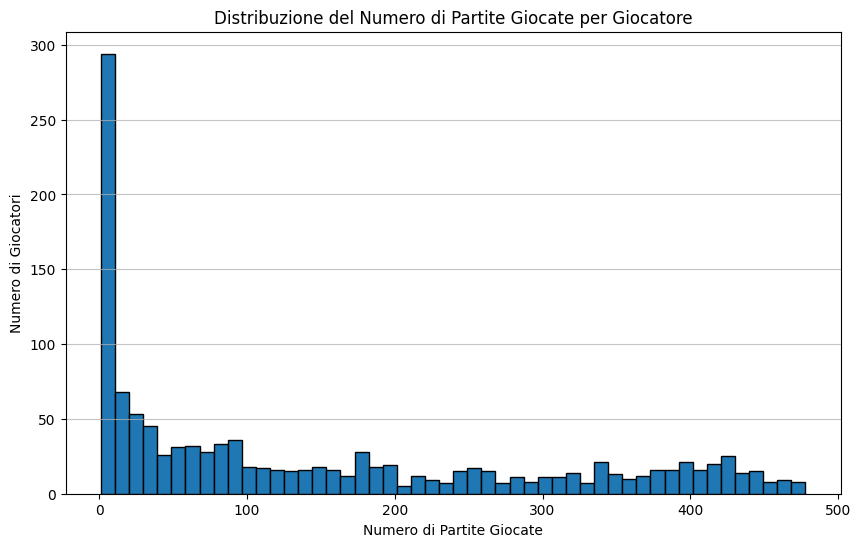


Top 5 Giocatori per Numero di Partite Giocate:
 playerId        playerName  gamesPlayed
   201980       Danny Green          478
     2617     Udonis Haslem          475
   202335 Patrick Patterson          474
   200782       P.J. Tucker          474
     2544      LeBron James          472

--- 3. Grado dei Nodi :Game (connessioni totali) ---

Statistiche Descrittive (Connessioni Totali per Partita):
count    6822.000000
mean       28.001612
std         2.870590
min        23.000000
25%        27.000000
50%        28.000000
75%        28.000000
max        42.000000


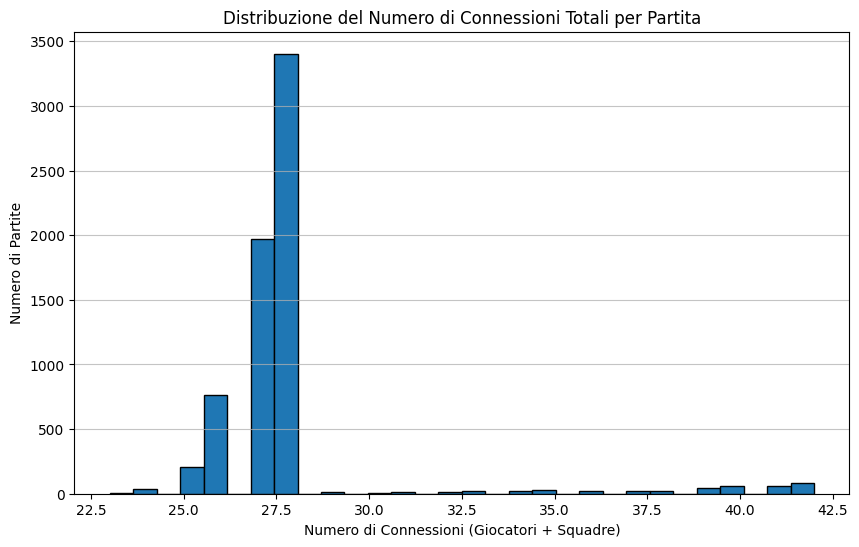


Top 5 Partite per Numero di Connessioni:
  gameId  totalConnections
11900079                42
11900069                42
11900065                42
11900068                42
11900059                42


In [ ]:
# Analisi della Distribuzione dei Gradi
import matplotlib.pyplot as plt
import numpy as np # Per calcoli statistici se necessario

print(f"--- Analisi della Distribuzione dei Gradi nel database: '{db_name}' ---")

try:
    with driver.session(database=db_name) as session:

        # --- 1. Grado dei Nodi :Player (partite giocate) ---
        print("\n--- 1. Grado dei Nodi :Player (numero di partite giocate) ---")
        player_degree_query = """
        MATCH (p:Player)-[r:PLAYED_IN_GAME]->(g:Game)
        RETURN p.playerId AS playerId, p.name AS playerName, count(g) AS gamesPlayed
        ORDER BY gamesPlayed DESC
        """
        results_players = session.run(player_degree_query)
        player_degrees = [{"playerId": r["playerId"], "playerName": r["playerName"], "gamesPlayed": r["gamesPlayed"]} for r in results_players]
        
        if player_degrees:
            df_player_degrees = pd.DataFrame(player_degrees)
            print("\nStatistiche Descrittive (Partite Giocate per Giocatore):")
            print(df_player_degrees['gamesPlayed'].describe().to_string())
            
            # Istogramma
            plt.figure(figsize=(10, 6))
            plt.hist(df_player_degrees['gamesPlayed'], bins=50, edgecolor='black')
            plt.title('Distribuzione del Numero di Partite Giocate per Giocatore')
            plt.xlabel('Numero di Partite Giocate')
            plt.ylabel('Numero di Giocatori')
            plt.grid(axis='y', alpha=0.75)
            plt.show()
            
            print("\nTop 5 Giocatori per Numero di Partite Giocate:")
            print(df_player_degrees.head(5).to_string(index=False))
        else:
            print("Nessun dato trovato per il grado dei giocatori.")

        print("\n--- 2. Grado dei nodi :Team (numero di partite distinte giocate)")
        team_degree_query = """
        MATCH (t:Team)-[:HOSTED_GAME | VISITED_GAME]->(g:Game)
        return t.teamId as teamId, t.nickname ad teamName, count(distinct g) as distinctGamesInvolved
        order by distinctGamesInvolved DESC
        """

        results_teams = session.run(team_degree_query)
        team_degrees = [{"teamId": r["teamId"], "teamName": r["teamName"], "distinctGamesInvolved": r["distinctGamesInvolved"]} for r in results_teams]
   
        if team_degrees:
            df_team_degrees = pd.DataFrame(team_degrees)
            print("\nStatistiche Descrittive (Partite Distinte per Squadra):")
            print(df_team_degrees['distinctGamesInvolved'].describe().to_string())

            plt.figure(figsize=(10, 6))
            # Adatta i bin in base al range dei nuovi valori, che sarà molto più piccolo
            # Potresti usare un numero fisso di bin, es. bins=15 o bins=20
            max_games = df_team_degrees['distinctGamesInvolved'].max()
            min_games = df_team_degrees['distinctGamesInvolved'].min()
            bin_width = 10 # Esempio, regola se necessario
            if max_games is not None and min_games is not None and max_games > min_games :
                 bins_calculated = int((max_games - min_games) / bin_width) if int((max_games - min_games) / bin_width) > 0 else 10
            else:
                 bins_calculated = 10 # Fallback
            plt.hist(df_team_degrees['distinctGamesInvolved'], bins=bins_calculated, edgecolor='black')
            plt.title('Distribuzione del Numero di Partite Distinte Giocate per Squadra')
            plt.xlabel('Numero di Partite Distinte Giocate')
            plt.ylabel('Numero di Squadre')
            plt.grid(axis='y', alpha=0.75)
            plt.show()
            
            print("\nSquadre ordinate per Numero di Partite Distinte Giocate (Top 5):")
            print(df_team_degrees.head(5).to_string(index=False))
        else:
            print("Nessun dato trovato per il grando delle squadre")


        # --- 3. Grado dei Nodi :Game (numero di giocatori + squadre connesse) ---
        print("\n--- 3. Grado dei Nodi :Game (connessioni totali) ---")
        # Il grado di un nodo Game è il numero di giocatori che vi hanno partecipato 
        # più le 2 squadre (casa e ospite).
        game_degree_query = """
        MATCH (g:Game)
        OPTIONAL MATCH (p:Player)-[:PLAYED_IN_GAME]->(g)
        OPTIONAL MATCH (t:Team)-[:HOSTED_GAME|VISITED_GAME]->(g) // Relazioni con le squadre
        RETURN g.gameId AS gameId, count(DISTINCT p) + count(DISTINCT t) AS totalConnections
        ORDER BY totalConnections DESC
        """
        # count(DISTINCT p) conta i giocatori unici per partita.
        # count(DISTINCT t) dovrebbe essere 2 per ogni partita.
        results_games = session.run(game_degree_query)
        game_degrees = [{"gameId": r["gameId"], "totalConnections": r["totalConnections"]} for r in results_games]
        
        if game_degrees:
            df_game_degrees = pd.DataFrame(game_degrees)
            print("\nStatistiche Descrittive (Connessioni Totali per Partita):")
            print(df_game_degrees['totalConnections'].describe().to_string())

            plt.figure(figsize=(10, 6))
            plt.hist(df_game_degrees['totalConnections'], bins=30, edgecolor='black')
            plt.title('Distribuzione del Numero di Connessioni Totali per Partita')
            plt.xlabel('Numero di Connessioni (Giocatori + Squadre)')
            plt.ylabel('Numero di Partite')
            plt.grid(axis='y', alpha=0.75)
            plt.show()

            print("\nTop 5 Partite per Numero di Connessioni:")
            print(df_game_degrees.head(5).to_string(index=False))
        else:
            print("Nessun dato trovato per il grado delle partite.")
            
except Exception as e:
    print(f"Si è verificato un errore durante l'analisi della distribuzione dei gradi: {e}")
